# ЛР2 — СИИ. Чураков А.А. P3331 409856

## Задание

Применить для своих данных из ЛР1 разыне методы кросс-валидации (не менее 5), и сравнить результаты.

## Подготовка данных

In [ ]:
!curl -L -o "$(pwd)/mobile-phone-price.zip" "https://www.kaggle.com/api/v1/datasets/download/rkiattisak/mobile-phone-price"
!unzip -o mobile-phone-price.zip

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, matplotlib.ticker as ticker
from math import sqrt
from sklearn.model_selection import (train_test_split, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupKFold)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sns.set_style("whitegrid")
plt.style.use("bmh")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  4821  100  4821    0     0  12072      0 --:--:-- --:--:-- --:--:-- 12072
Archive:  mobile-phone-price.zip
  inflating: Mobile phone price.csv  


In [ ]:
df = pd.read_csv("Mobile phone price.csv").rename(columns=str.strip)

for col in ["Storage", "RAM"]:
    df[col] = df[col].str.replace(r"[^0-9]", "", regex=True).astype(int)

df["Battery"] = df["Battery Capacity (mAh)"].astype(str).str.replace(r"[^0-9]", "", regex=True).astype(int)
df["Price"] = df["Price ($)"].astype(str).str.replace(r"[^0-9]", "", regex=True).astype(int)

df["Camera"] = (
    df["Camera (MP)"]
    .astype(str)
    .str.replace(r"[^0-9\+]", "", regex=True)
    .str.split("+")
    .apply(lambda lst: sum(float(x) for x in lst if x.strip() != ""))
)

df["ScreenSize"] = (
    df["Screen Size (inches)"]
    .astype(str)
    .str.replace(r"[^0-9\+\.]", "", regex=True)
    .str.split("+")
    .apply(lambda lst: sum(float(x) for x in lst if x.strip() != ""))
)

df = df[["Brand", "Model", "Storage", "RAM", "ScreenSize", "Battery", "Camera", "Price"]]

X = df.drop(columns=["Price", "Model"])
y = df["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Пайплайн модели

In [ ]:
numeric_features = ["Storage", "RAM", "ScreenSize", "Battery", "Camera"]
categorical_features = ["Brand"]

preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)],
    remainder="passthrough"
)
pipe = Pipeline([("prep", preprocessor), ("model", LinearRegression())])

## Helper functions

In [ ]:

def rmse(y_true, y_pred): return sqrt(mean_squared_error(y_true, y_pred))

def run_cv(model, X_train, y_train, X_test, folds, *, groups=None):
    oof, test_pred, scores, train_idx, val_idx = (
        np.zeros(len(y_train)), np.zeros(len(X_test)), [], [], []
    )

    idx = np.arange(len(y_train))

    for tr, va in folds.split(X_train, y_train, groups=groups):
        model.fit(X_train.iloc[tr], y_train.iloc[tr])
        preds = model.predict(X_train.iloc[va])
        oof[va] = preds
        scores.append(rmse(y_train.iloc[va], preds))
        test_pred += model.predict(X_test)
        train_idx.append(idx[tr])
        val_idx.append(idx[va])

    test_pred /= folds.get_n_splits()

    return dict(
        cv_rmse_mean=np.mean(scores),
        cv_rmse_std=np.std(scores),
        test_pred=test_pred,
        train_folds=train_idx,
        valid_folds=val_idx
    )

def price_bins(y, n_bins=5): return pd.qcut(y, q=n_bins, duplicates="drop", labels=False)

## Методы кросс-валидации

In [ ]:
import random
seed = random.randint(0, 10000)

cv_methods = [
    ("KFold", KFold(n_splits=5, shuffle=False)),
    ("KFold+Shuffle", KFold(n_splits=5, shuffle=True, random_state=seed)),
    ("ShuffleSplit", ShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)),
    ("StratifiedKFold(q=5)", StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)),
    ("GroupKFold(Brand)", GroupKFold(n_splits=5)),
]

results = []
for name, cv in cv_methods:
    if "Group" in name:
        res = run_cv(pipe, X_train, y_train, X_test, cv, groups=X_train["Brand"])
    elif "Stratified" in name:
        y_bins = price_bins(y_train, n_bins=5)
        res = run_cv(pipe, X_train, y_train, X_test, cv)
    else:
        res = run_cv(pipe, X_train, y_train, X_test, cv)
    results.append((name, res))

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


## Сравнение метрик

                     CV  CV_RMSE_mean  CV_RMSE_std   TEST_RMSE
0                 KFold    153.772711    36.341530  128.745434
3  StratifiedKFold(q=5)    164.404395    36.335460  129.297034
1         KFold+Shuffle    171.612560    55.009420  129.956620
4     GroupKFold(Brand)    288.350148    86.332271  135.167398
2          ShuffleSplit    175.629649    42.935269  138.313289


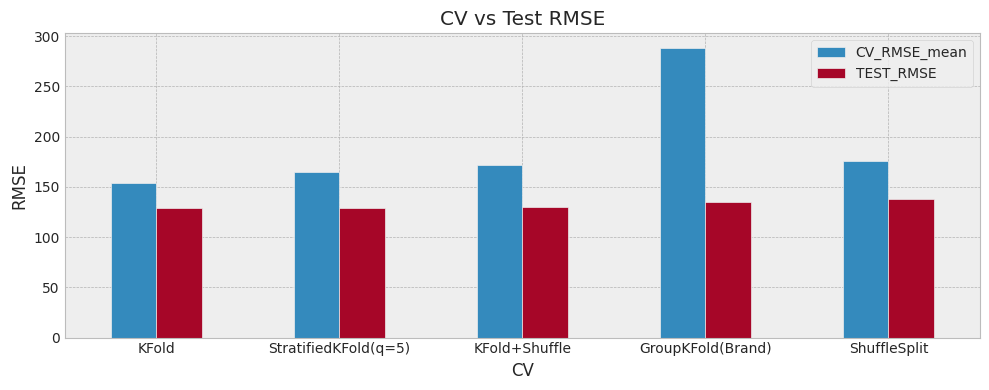

In [ ]:
stats = pd.DataFrame([{
    "CV": name,
    "CV_RMSE_mean": res["cv_rmse_mean"],
    "CV_RMSE_std": res["cv_rmse_std"],
    "TEST_RMSE": rmse(y_test, res["test_pred"])
} for name, res in results
]).sort_values("TEST_RMSE")

print(stats)

ax = stats.plot(x="CV", y=["CV_RMSE_mean", "TEST_RMSE"], kind="bar", figsize=(10,4), rot=0)
ax.set_ylabel("RMSE");
ax.set_title("CV vs Test RMSE")
plt.tight_layout();
plt.show()

## Графики для всех методов

In [ ]:
def plot_cv_folds(title, y_train, y_test, train_folds, valid_folds):
    fig, ax = plt.subplots(1, 2, gridspec_kw={"width_ratios": [3, 1]}, figsize=(25,5))
    colors = ["#f7bb05", "#2e2b23"]
    sns.set_palette(sns.color_palette(colors))

    for i, (tr_idx, va_idx) in enumerate(zip(train_folds, valid_folds)):
        folds_df = pd.DataFrame({
            "x": np.r_[tr_idx, va_idx],
            "Fold": i,
            "Type": ["train"]*len(tr_idx) + ["valid"]*len(va_idx)
        })
        sns.scatterplot(x="x", y="Fold", data=folds_df, hue="Type",
                        marker="|", s=300, alpha=1, linewidth=1, ax=ax[0], legend=(i==len(train_folds)-1))

        sns.histplot(y_train.iloc[va_idx], kde=False, bins=30, alpha=0.25, ax=ax[1])

    sns.histplot(y_test, kde=False, bins=30, ax=ax[1], color="#2680c9")
    ax[0].set_xlabel("sample index"); ax[0].set_ylabel("Fold Number")
    ax[0].set_title(title, fontsize=18, fontweight="bold")
    ax[1].set_title("Validation folds vs Test target distribution", fontsize=18, fontweight="bold")
    plt.tight_layout(); plt.show()

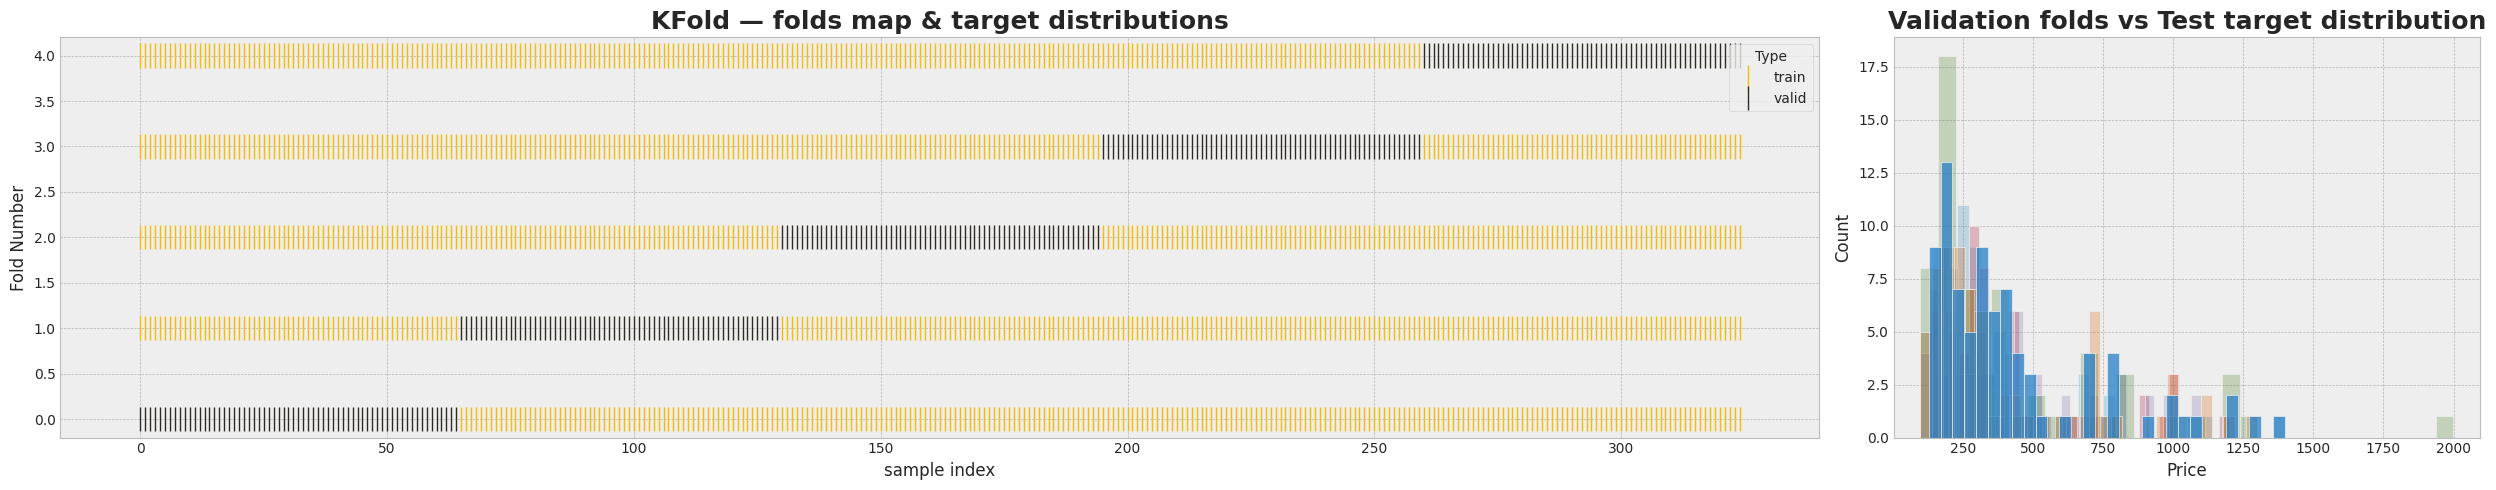

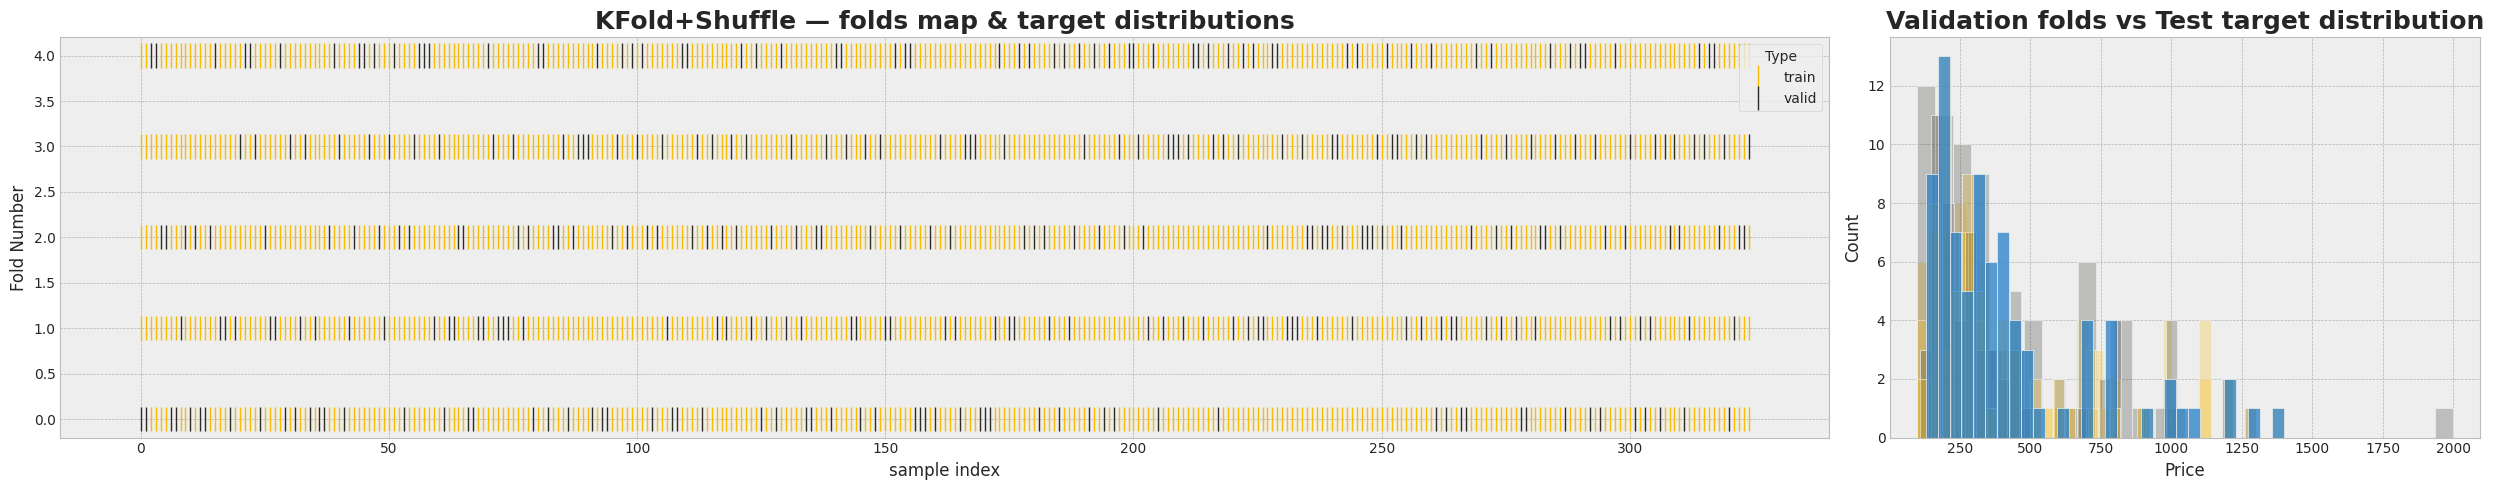

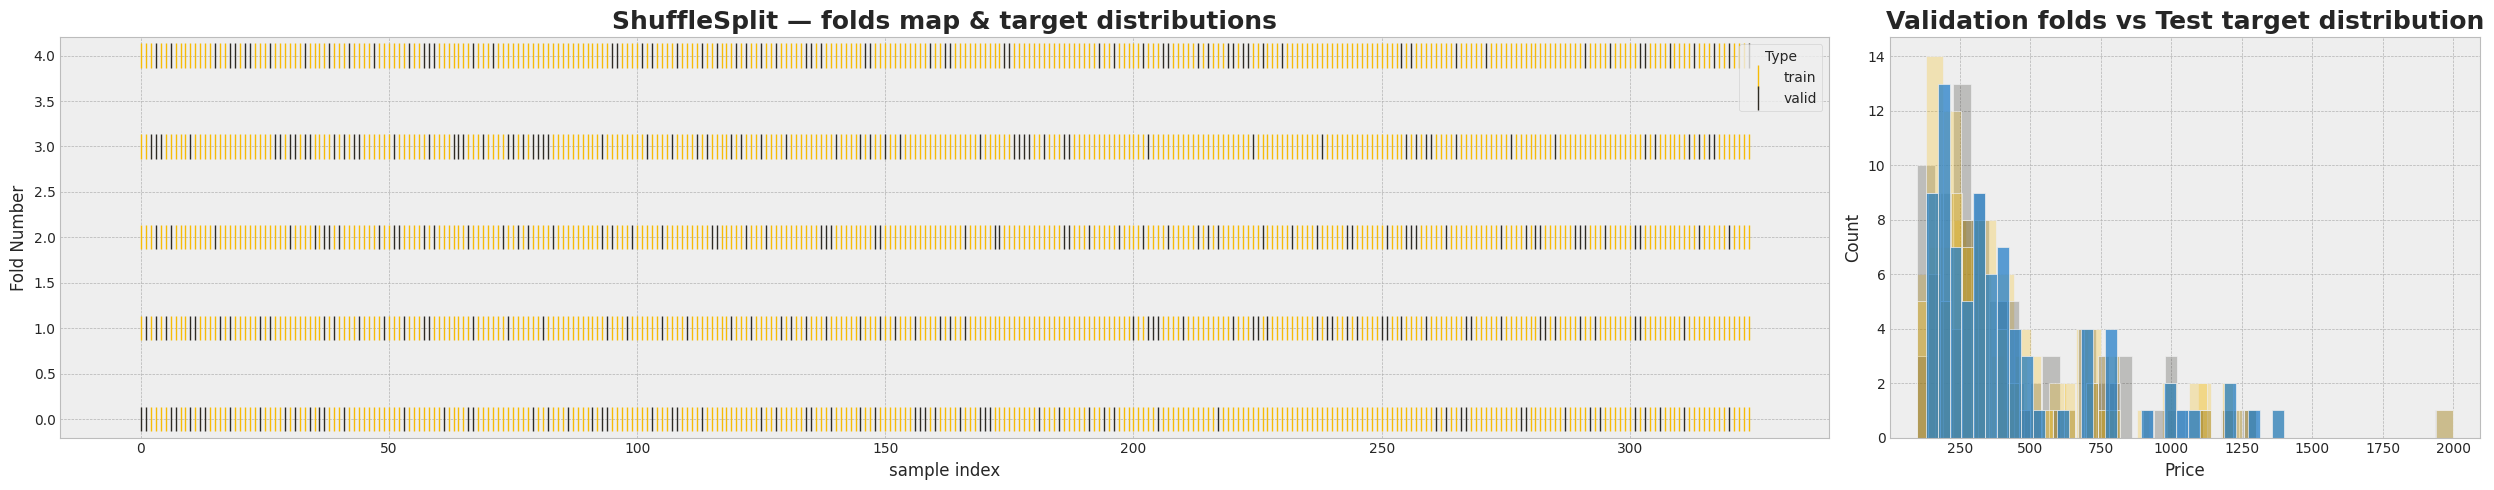

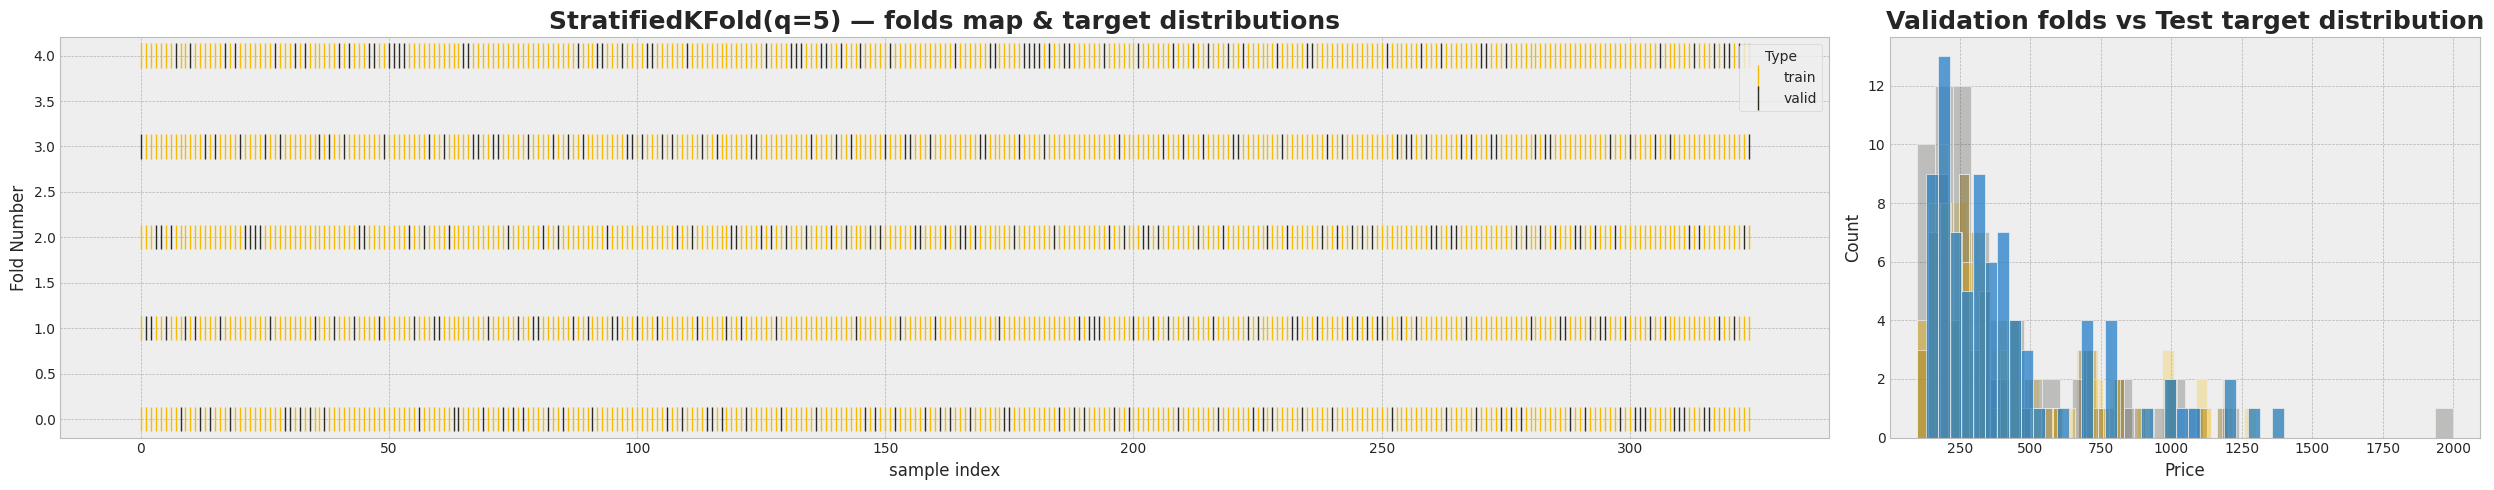

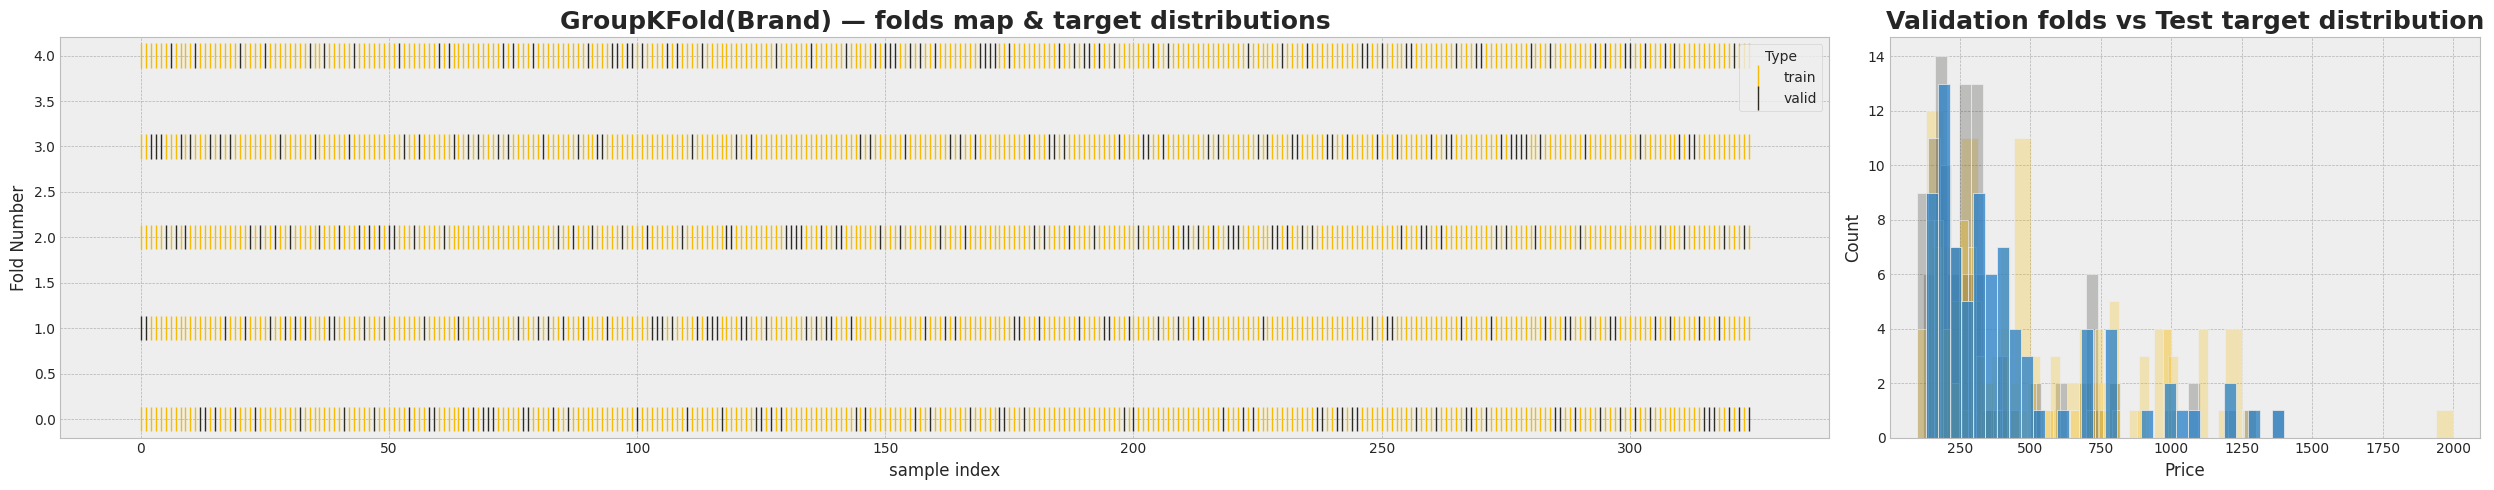

In [ ]:
for name, res in results:
    plot_cv_folds(f"{name} — folds map & target distributions",
                  y_train, y_test, res["train_folds"], res["valid_folds"])